In [33]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
data = xr.open_dataset("./data/ts_Amon_CESM2_piControl_r1i1p1f1.nc")["ts"]
#data = xr.open_dataset("./data/zos_Amon_CESM2_piControl_r1i1p1f1.nc")["zos"]
#data_old = xr.open_dataset("./data/ssta_1950_2021.nc")["ssta"]
mask = xr.open_dataset("./data/sftlf_fx_CESM2_historical_r1i1p1f1.nc")["sftlf"]

#14400 orginial size
data = data[:, :, :]

data = ut.apply_mask(mask, data)
#print("Data : {} + shape {}".format(data, data.shape))

data_anomalies = ut.calculate_monthly_anomalies(data)
#print("Month mean : {} + shape : {}".format(data_anomalies, data_anomalies.shape))

data_cropped =ut.crop_xarray(data_anomalies)
#print("Data cropped : {} + shape : {}".format(data_cropped, data_cropped.shape))


pca_10 = ut.SpatioTemporalPCA(data_cropped, n_components=20)
#pca_10 = ut.SpatioTemporalPCA(data_anomalies, n_components=20)
eof_10 = pca_10.eofs()
pc_10 = pca_10.principal_components()

# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

eps = 0.01

# Get input data
x_input = data_train.isel(time=0)
x_input = x_input.data

# original fit
tau = 1
model_org = LIM_class.LIM(tau)
model_org.fit(data_train.data, eps=eps)

eigenvalues_lst = []


for t in range(40):

    print("Iteration : {}".format(t))

        # Forecast mean using LIM model
    lim_integration, times_ = model_org.noise_integration(x_input, timesteps=50000, num_comp=len(pc_10), seed=t)
    lim_integration = lim_integration.T

    tau = 1
    model = LIM_class.LIM(tau)
    model.fit(lim_integration, eps=eps)

    logar_matr = model.logarithmic_matrix
    noise_matr = model.noise_covariance

    # Plotting eigenvalues of G
    eigenvalues, _, w = ut.matrix_decomposition(model.green_function)
    eigenvalues_lst.append(eigenvalues)


eigenvalues_org, _, w = ut.matrix_decomposition(model_org.green_function)


Covariance matrix has negative values!
Iteration : 0
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 1
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 2
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 3
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 4
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 5
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 6
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 7
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 8
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 9
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 10
Negative eigenvalues detected.
Covariance matrix has negative values!
Iteration : 11
Negative eigenvalues 

ValueError: x and y must have same first dimension, but have shapes (20,) and (39, 20)

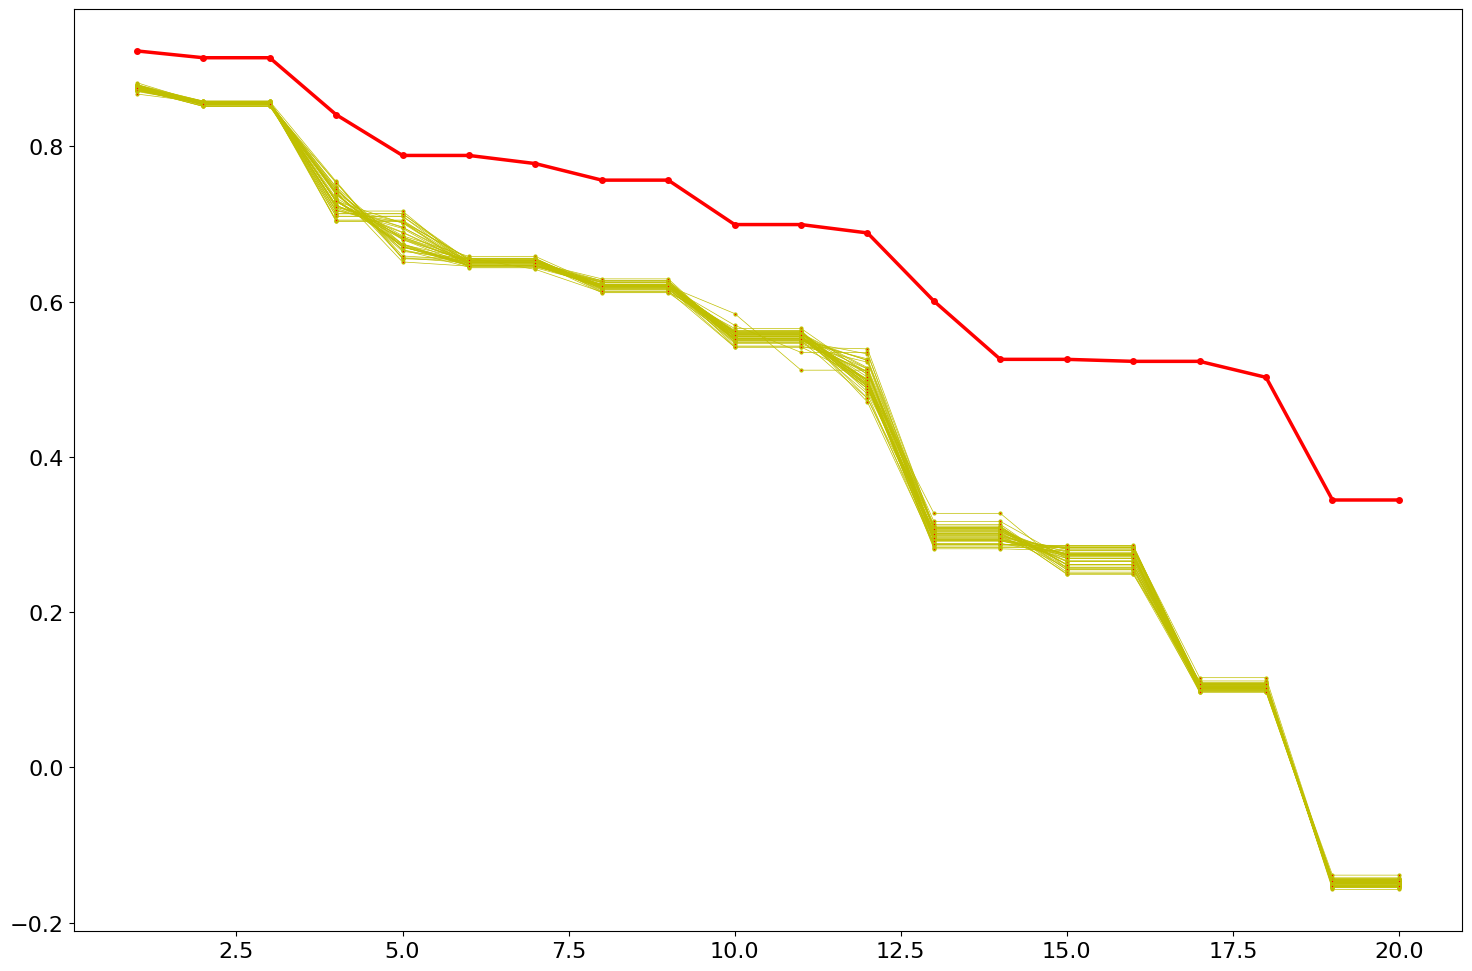

In [36]:
x = np.arange(1, len(eigenvalues) + 1)

# Plot the eigenvalues
plt.figure(figsize=(15,10))
plt.plot(x, eigenvalues_org, marker='o', linestyle='-', color='r', markersize=4, markerfacecolor='r', linewidth=2.5,
         label='G')

for y in range(len(eigenvalues_lst)):
    plt.plot(x, eigenvalues_lst[y], marker='o', linestyle='-', color='y', markersize=2, markerfacecolor='r', linewidth=0.5)

plt.plot(x, eigenvalues_lst[:39], marker='o', linestyle='-', color='y', markersize=2, markerfacecolor='r', linewidth=0.5,
     label='G_new')
#plt.plot(x, eigenvalues_lst[11], marker='o', linestyle='-', color='g', markersize=4, markerfacecolor='r', linewidth=0.5,
#     label='G*')
#plt.plot(x, eigenvalues_lst[12], marker='o', linestyle='-', color='r', markersize=4, markerfacecolor='r', linewidth=0.5)


# Set the labels and title
plt.xlabel('Index', fontsize=20, labelpad=20)
plt.ylabel('Eigenvalue', fontsize=20, labelpad=20)
plt.title('Eigenvalues of G / G_new', fontsize=15)

# Set the x-axis tick labels
plt.xticks(x, fontsize=20)
plt.legend(loc="upper right", fontsize=12)

# Display the plot
plt.savefig('./plots/svg/eigenvalues_G_combined_piControl_.svg', format='svg')
plt.savefig('./plots/png/eigenvalues_G_combined_piControl_.png', format='png')
plt.show()